In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.1 MB/s eta 0:00:00


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 38.8 MB/s eta 0:00:00


In [ ]:
!pip install geopandas

In [ ]:
!pip install Fiona GDAL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.7 MB/s eta 0:00:00


In [ ]:
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
# Instalar o pacote do Google Earth Engine
!pip install earthengine-api --quiet
!pip install geemap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import rasterio
import rioxarray

In [ ]:

# Importar as bibliotecas necessárias
import ee
import geemap

In [ ]:
# Autenticar o Google Earth Engine
ee.Authenticate()

In [ ]:

# Inicializar a biblioteca do Earth Engine
ee.Initialize(project='ee-josieltonsantos1')

In [ ]:
# insira o mês e ano de análise Ex.: "Dezembro de 2024"
mesatual = "Dezembro de 2024"

In [ ]:
# Configurar a data 'ano-mes-dia'
start_date = '2024-12-01'
end_date = '2024-12-31'

In [ ]:
# Carregar o dataset do MODIS
dataset = ee.ImageCollection('MODIS/061/MOD13Q1').filterDate(start_date, end_date)
ndvi = dataset.select('NDVI')
evi = dataset.select('EVI')
# Calcular a média de NDVI e EVI no intervalo de datas
ndvi_mean = ndvi.mean()
evi_mean = evi.mean()

In [ ]:
# Definir a geometria (região de interesse)
# Essas coordenads descrevem um retângulo.

geometry = ee.Geometry.Rectangle([-38.6, -11.7, -36.1, -9.3])

In [ ]:
# Listar as imagens da ImageCollection
image_list = dataset.toList(dataset.size())

# Exibir informações sobre as imagens da coleção
for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))
    date = image.get('system:time_start')  # A data de referência
    print(f"Imagem {i+1}:")
    print(f"Data de referência: {ee.Date(date).format('YYYY-MM-dd').getInfo()}")
    #print(f"Propriedades: {image.propertyNames().getInfo()}")
    print("-----")

Imagem 1:
Data de referência: 2024-12-02
-----
Imagem 2:
Data de referência: 2024-12-18
-----


In [ ]:
# Exportar as imagens para o Google Drive
ndvi_task = ee.batch.Export.image.toDrive(
    image=ndvi_mean,
    description='ndvi_mean_export',
    folder='EarthEngine',
    fileNamePrefix=f'ndvi_{mesatual}',
    scale=250,
    region=geometry.bounds().getInfo()['coordinates'],
    maxPixels=1e13
)

evi_task = ee.batch.Export.image.toDrive(
    image=evi_mean,
    description='evi_mean_export',
    folder='EarthEngine',
    fileNamePrefix=f'evi_{mesatual}',
    scale=250,
    region=geometry.bounds().getInfo()['coordinates'],
    maxPixels=1e13
)

# Iniciar as tarefas de exportação
ndvi_task.start()
evi_task.start()

# Monitorar o status da exportação
print("Exportando para o Google Drive. Verifique o status da exportação na sua pasta EarthEngine.")


Exportando para o Google Drive. Verifique o status da exportação na sua pasta EarthEngine.


In [ ]:
raster_file = rioxarray.open_rasterio(f'/content/drive/MyDrive/EarthEngine/ndvi_{mesatual}.tif')

In [ ]:
#aplicar a escala do ndvi
ds = raster_file.squeeze()*0.0001

In [ ]:
imgg = Image.open('/content/drive/MyDrive/UFV/Projeto/Dados/shapes/nsimpls.jpg')

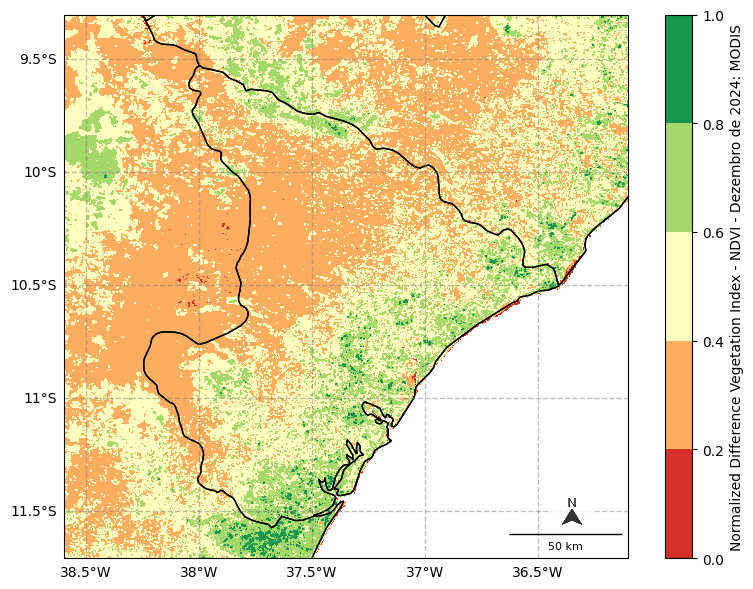

In [ ]:
# definir a projeção do mapa
proj = ccrs.PlateCarree()

# criar figura e eixos com a projeção desejada
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# plotar os dados na figura
lon = ds.coords['x'].values
lat = ds.coords['y'].values
cs = ax.contourf(lon, lat, ds, cmap='RdYlGn', levels=np.arange(0, 1.1, 0.2))

# adicionar barra de cores
cbar = plt.colorbar(cs, orientation='vertical')
cbar.ax.set_ylabel(f'Normalized Difference Vegetation Index - NDVI - {mesatual}: MODIS')

# adicionar título e texto nos eixos
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# adiciona a coastline e os labels de latitude e longitude
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Adiciona as latitudes e longitudes
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=proj)
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Adiciona a scalebar na figura
scalebar = AnchoredSizeBar(ax.transData,
                           0.5, '50 km', 'lower right',
                           pad=0.5, sep=5,
                           color='black', frameon=False,
                           size_vertical=0.0025, fontproperties={'size': 8})
ax.add_artist(scalebar)

# define a posição e o tamanho da imagem
im = OffsetImage(imgg, zoom=0.15, alpha=0.8)
ab = AnnotationBbox(im, (-36.35, -11.5), xycoords='data', frameon=False)

# adiciona a imagem no mapa
ax.add_artist(ab)

# Ajusta o espaçamento entre os subplots
fig.tight_layout()
plt.savefig(f'ndvi_{mesatual}_se_MODIS.png', dpi=300)
# exibir a figura
plt.show()

In [ ]:
raster_file = rioxarray.open_rasterio(f'/content/drive/MyDrive/EarthEngine/evi_{mesatual}.tif')

In [ ]:
#aplicar a escala do Evi
ds = raster_file.squeeze()*0.0001

In [ ]:
mycolors = ['sienna', 'lightgreen', 'yellowgreen' , 'green', 'darkgreen' ]

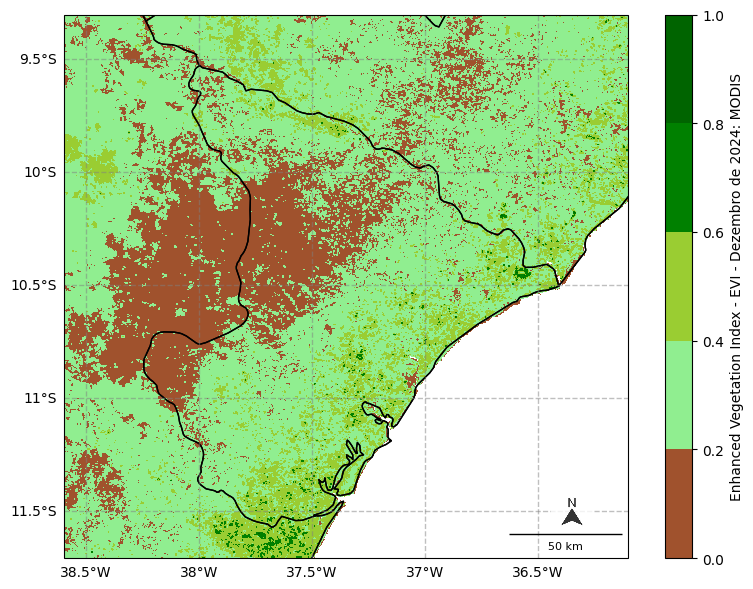

In [ ]:
# definir a projeção do mapa
proj = ccrs.PlateCarree()

# criar figura e eixos com a projeção desejada
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# plotar os dados na figura
lon = ds.coords['x'].values
lat = ds.coords['y'].values
cs = ax.contourf(lon, lat, ds, colors=mycolors, levels=np.arange(0, 1.1, 0.2))

# adicionar barra de cores
cbar = plt.colorbar(cs, orientation='vertical')
cbar.ax.set_ylabel(f'Enhanced Vegetation Index - EVI - {mesatual}: MODIS')

# adicionar título e texto nos eixos
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# adiciona a coastline e os labels de latitude e longitude
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Adiciona o contorno do shapefile de área de estudo
#ax.add_geometries(bacia["geometry"], crs=proj, edgecolor="black", facecolor="none")

# Adiciona as latitudes e longitudes
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=proj)
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Adiciona a scalebar na figura
scalebar = AnchoredSizeBar(ax.transData,
                           0.5, '50 km', 'lower right',
                           pad=0.5, sep=5,
                           color='black', frameon=False,
                           size_vertical=0.0025, fontproperties={'size': 8})
ax.add_artist(scalebar)

# define a posição e o tamanho da imagem
im = OffsetImage(imgg, zoom=0.15, alpha=0.8)
ab = AnnotationBbox(im, (-36.35, -11.5), xycoords='data', frameon=False)

# adiciona a imagem no mapa
ax.add_artist(ab)

# Ajusta o espaçamento entre os subplots
fig.tight_layout()
plt.savefig(f'evi_{mesatual}_se_MODIS.png', dpi=300)
# exibir a figura
plt.show()